In [96]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))
sys.path.append(str(Path.cwd().parent / 'label_anything' / 'data'))

In [97]:
from data.dataset import LabelAnythingDataset, VariableBatchSampler
from transforms import CustomResize, CustomNormalize

from label_anything import LabelAnything
from label_anything.experiment.substitution import Substitutor
from label_anything.utils.utils import ResultDict
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torchvision.transforms import Compose, ToTensor, Resize, PILToTensor
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader
import timeit
from PIL import Image
import numpy as np
import cv2
import lovely_tensors as lt
from einops import rearrange
from sklearn.decomposition import PCA
import torch.nn as nn
lt.monkey_patch()

In [98]:
RAW_DATA_DIR = Path.cwd().parent / "data"

In [99]:
preprocess = Compose([
    CustomResize(1024),
    PILToTensor(),
    CustomNormalize()
])

In [100]:
dataset = LabelAnythingDataset(
    {
        "pascal5i": {
            "name": "pascal",
            "data_dir": RAW_DATA_DIR / "pascal",
            "preprocess": preprocess,
            'split': 'train',
            'val_fold_idx': 0,
            'n_folds': 4,
            'sample_function': 'uniform',
            'all_example_categories': False,
        }
    }, {}
)

Loading image filenames from train...
[2024-11-06 11:00:27] WARNING - pascal.py - load_embeddings is not specified. Assuming load_embeddings=False.


Loading annotations...:   0%|          | 0/12046 [00:00<?, ?it/s]

Loading annotations...: 100%|██████████| 12046/12046 [00:14<00:00, 815.49it/s]


In [101]:
sampler = VariableBatchSampler(
        dataset,
        possible_batch_example_nums=[[1, 2, 1]],
        num_processes=1,
        shuffle=False,
)

In [102]:
dataloader = DataLoader(
        dataset=dataset, batch_sampler=sampler, collate_fn=dataset.collate_fn
)

In [ ]:
la = LabelAnything.from_pretrained("pasqualedem/label_anything_256_sam_1024_coco").model.eval()

In [103]:
idx = 2
for batch_idx, ((batch, gt), _) in enumerate(dataloader):
    print(batch_idx)
    if batch_idx == idx:
        break 

0
1
2


In [104]:
dataset.categories

{'pascal5i': {6: {'name': 'bus'},
  7: {'name': 'car'},
  8: {'name': 'cat'},
  9: {'name': 'chair'},
  10: {'name': 'cow'},
  11: {'name': 'diningtable'},
  12: {'name': 'dog'},
  13: {'name': 'horse'},
  14: {'name': 'motorbike'},
  15: {'name': 'person'},
  16: {'name': 'pottedplant'},
  17: {'name': 'sheep'},
  18: {'name': 'sofa'},
  19: {'name': 'train'},
  20: {'name': 'tvmonitor'}}}

In [105]:
batch

{'images': tensor[1, 3, 3, 1024, 1024] n=9437184 (36Mb) x∈[-2.118, 1.136e+03] μ=381.813 σ=356.480,
 'prompt_points': tensor[1, 3, 3, 1, 2] n=18 all_zeros,
 'flag_points': tensor[1, 3, 3, 1] n=9 all_zeros [[[[0.], [0.], [0.]], [[0.], [0.], [0.]], [[0.], [0.], [0.]]]],
 'prompt_bboxes': tensor[1, 3, 3, 1, 4] n=36 all_zeros,
 'flag_bboxes': tensor[1, 3, 3, 1] n=9 all_zeros [[[[0.], [0.], [0.]], [[0.], [0.], [0.]], [[0.], [0.], [0.]]]],
 'prompt_masks': tensor[1, 3, 3, 256, 256] n=589824 (2.2Mb) x∈[0., 1.000] μ=0.061 σ=0.240,
 'flag_masks': tensor[1, 3, 3] u8 n=9 x∈[0, 1] μ=0.333 σ=0.500 [[[0, 0, 1], [0, 0, 1], [0, 1, 0]]],
 'flag_examples': tensor[1, 3, 3] u8 n=9 x∈[0, 1] μ=0.667 σ=0.500 [[[1, 0, 1], [1, 0, 1], [1, 1, 0]]],
 'dims': tensor[1, 3, 2] i64 n=6 x∈[332, 500] μ=430.333 σ=77.914 [[[500, 375], [375, 500], [332, 500]]],
 'classes': [[[15], [15], [10]]],
 'image_ids': [[('2008_005231', '/SegmentationClassAug/2008_005231.png'),
   ('2009_004781', '/SegmentationClassAug/2009_004781.pn

In [106]:
sample = {
    k: v[0] for k, v in batch.items()
}

In [107]:
def get_image(image_tensor):
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

In [108]:
def draw_masks(img: Image, masks: torch.Tensor, colors):
    # here masks is a dict having category names as keys
    # associated to a list of binary masks
    masked_image = resize(img.copy(), 256)
    
    for i, mask in enumerate(masks):
        mask = mask.numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

In [109]:
def draw_boxes(img: Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

In [110]:
def draw_points(img: Image, points: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(points):
        for point in cat:
            x, y = point
            x, y = int(x), int(y)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

In [111]:
def draw_all(img: Image, masks, boxes, points, colors):
    print("ciao")
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 1024)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

In [112]:
def resize_ground_truth(ground_truth, dims):
    return ground_truth[:dims[0], :dims[1]]

In [113]:
def feature_map_pca_heatmap(feature_map):
    """
    Given a feature map of shape (D, H, W), performs PCA along the feature dimension
    and returns a heatmap based on the first principal component.
    
    Args:
        feature_map (torch.Tensor): Input tensor of shape (D, H, W).
    
    Returns:
        heatmap (torch.Tensor): Heatmap of shape (H, W) based on the first principal component.
    """
    # Check the input dimensions
    D, H, W = feature_map.shape
    feature_map_reshaped = feature_map.view(D, -1).T  # Reshape to (H*W, D)

    # Convert to numpy for PCA
    feature_map_np = feature_map_reshaped.cpu().numpy()
    
    # Perform PCA
    pca = PCA(n_components=1)
    principal_component = pca.fit_transform(feature_map_np)
    
    # Reshape the result back to (H, W) and convert it to a tensor
    heatmap = torch.tensor(principal_component).view(H, W)
    
    # Normalize the heatmap for better visualization
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    return heatmap

In [114]:
colors = [
    # yellow
    (255, 255, 0),
    # red
    (255, 0, 0),
    # green
    (0, 255, 0),
    # blue
    (0, 0, 255),
    # purple
    (255, 0, 255),
    # cyan
    (0, 255, 255),
    # orange
    (255, 165, 0),
    # pink
    (255, 192, 203),
    # brown
    (139, 69, 19),
    # grey
    (128, 128, 128),
    # black
    (0, 0, 0)
]*3

In [115]:
images = [
    draw_all(
        get_image(sample["images"][i]),
        sample["prompt_masks"][i],
        sample["prompt_bboxes"][i],
        sample["prompt_points"][i],
        colors
    )
    for i in range(sample["images"].shape[0])
]

ciao
ciao
ciao


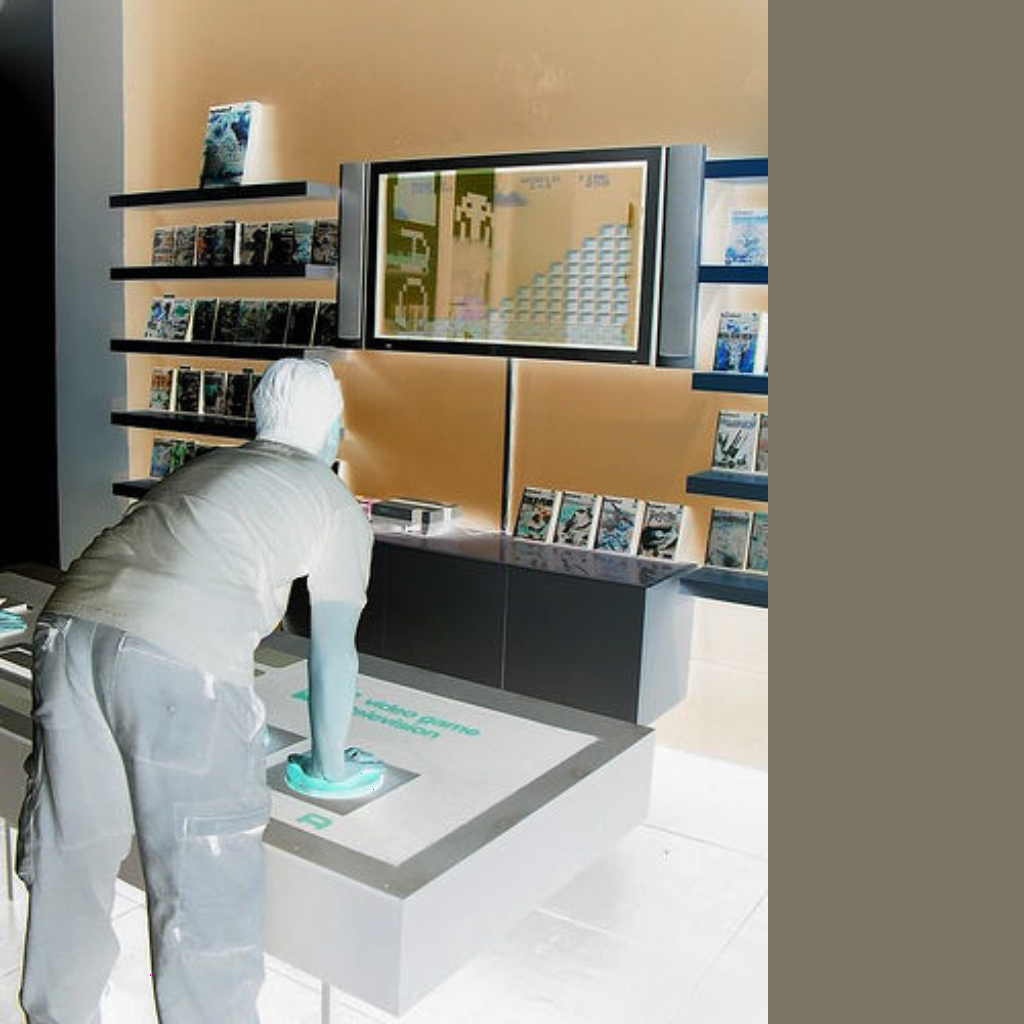

In [116]:
get_image(sample["images"][0])

0
person


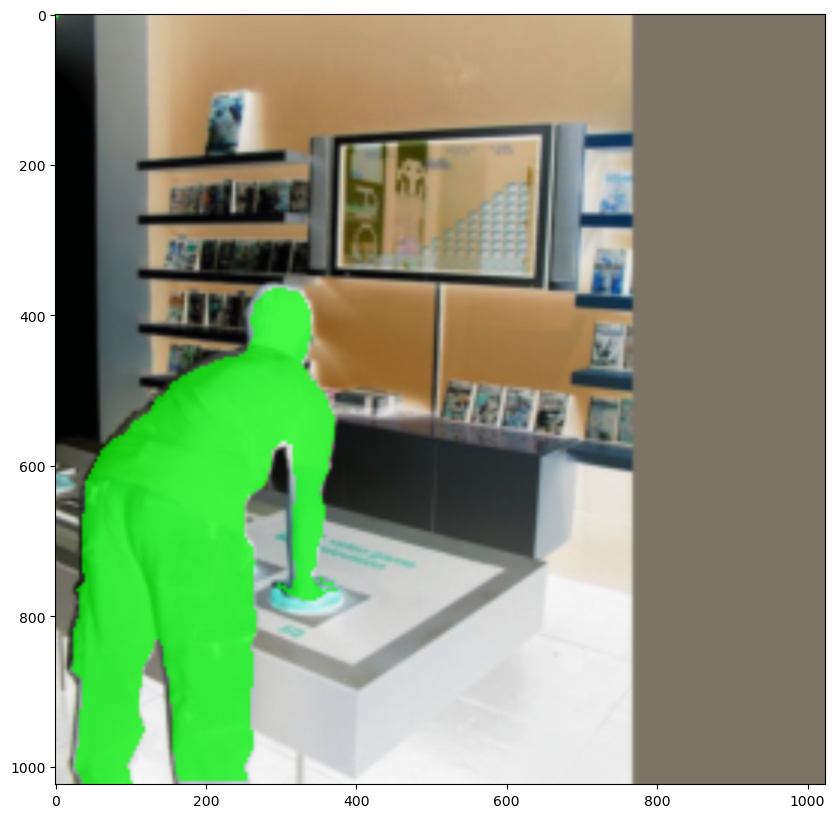

1
person


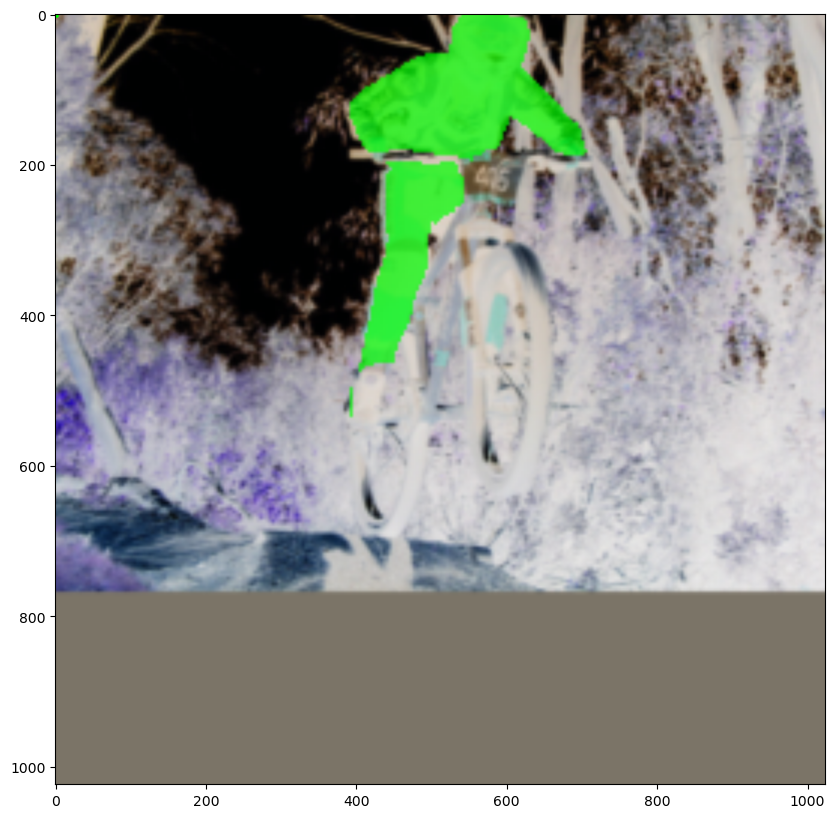

2
cow


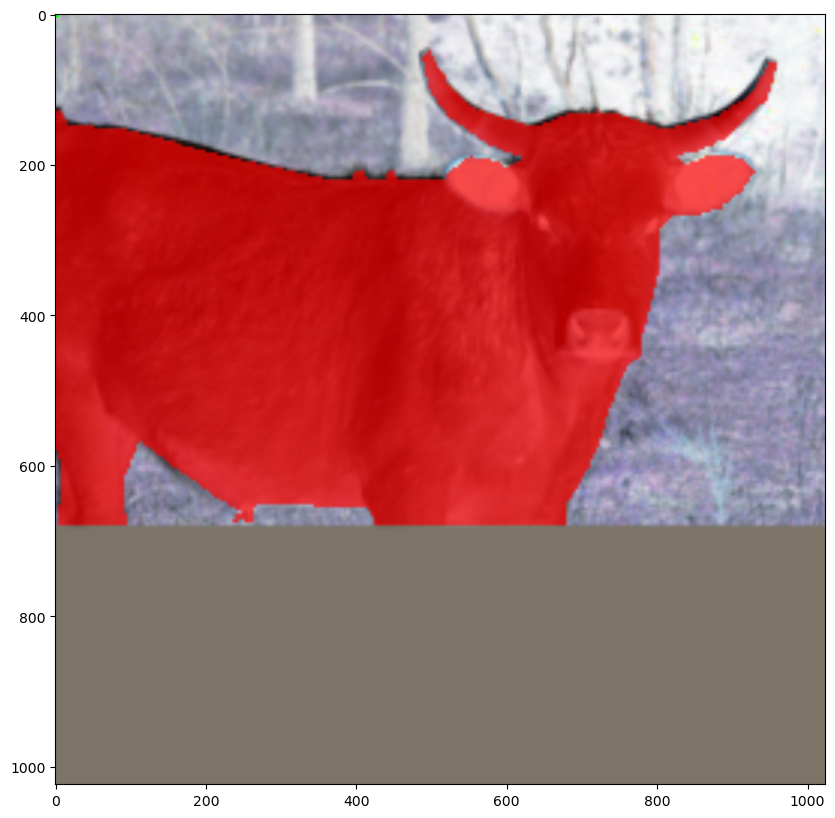

In [117]:
# show examples one by one
for i, example in enumerate(images):
    cats = [dataset.categories["pascal5i"][cat]["name"] for cat in sample["classes"][i]]
    print(i)
    print(", ".join(cats))
    plt.figure(figsize=(10, 10))
    plt.imshow(example)
    plt.show()

In [119]:
sub = Substitutor(substitute=False)
sub.reset((batch, gt))
batch_dict, gt = next(sub)

In [120]:
with torch.no_grad():
    query_embeddings, prompt_embeddings = la.prepare_query_example_embeddings(batch_dict)

In [121]:
q_pca = feature_map_pca_heatmap(query_embeddings[0])
s_pca = torch.stack([feature_map_pca_heatmap(prompt_embedding) for prompt_embedding in prompt_embeddings[0]])
qs_pca = torch.cat([q_pca.unsqueeze(0), s_pca], dim=0)

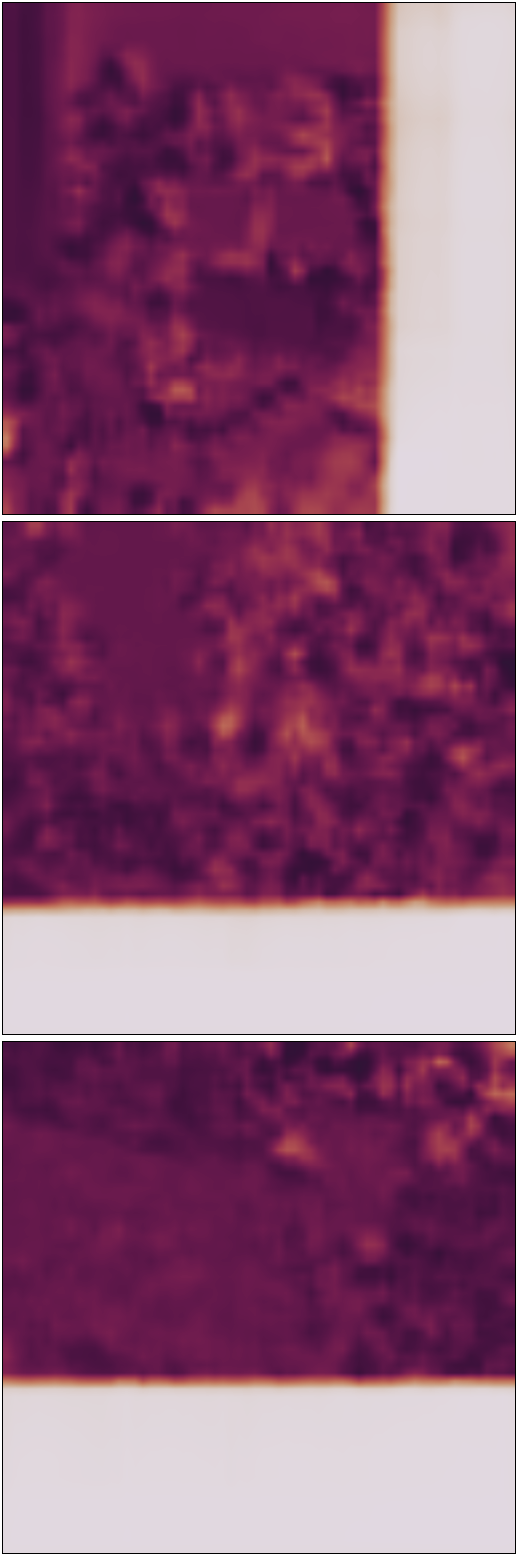

In [122]:
resized_qs_pca = resize(qs_pca, (512, 512)).squeeze(0)
resized_qs_pca.chans

In [123]:
with torch.no_grad():
    points, boxes, masks, flag_examples = la.prepare_prompts(batch_dict)
    sparse_embeddings, dense_embeddings = la.prompt_encoder.embed_points_masks(
        points, boxes, masks, chunk_size=None
    )
    sparse_embeddings = rearrange(sparse_embeddings, "b m c n d -> (b m c) n d")

    b, m, c, d, h, w = dense_embeddings.shape
    dense_embeddings = rearrange(dense_embeddings, "b m c d h w -> (b m c) d h w")

    if prompt_embeddings.shape[-2:] != dense_embeddings.shape[-2:]:
        dense_embeddings = nn.functional.interpolate(
            dense_embeddings,
            size=prompt_embeddings.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

    if la.prompt_encoder.use_support_features:
        src = rearrange(prompt_embeddings, "b m d h w -> b m 1 d h w").repeat(
            1, 1, c, 1, 1, 1
        )
        src = rearrange(src, "b m c d h w -> (b m c) d h w")
        src = src + dense_embeddings
    else:
        src = dense_embeddings
    pos_src = torch.repeat_interleave(
        la.prompt_encoder.get_dense_pe(), sparse_embeddings.shape[0], dim=0
    )

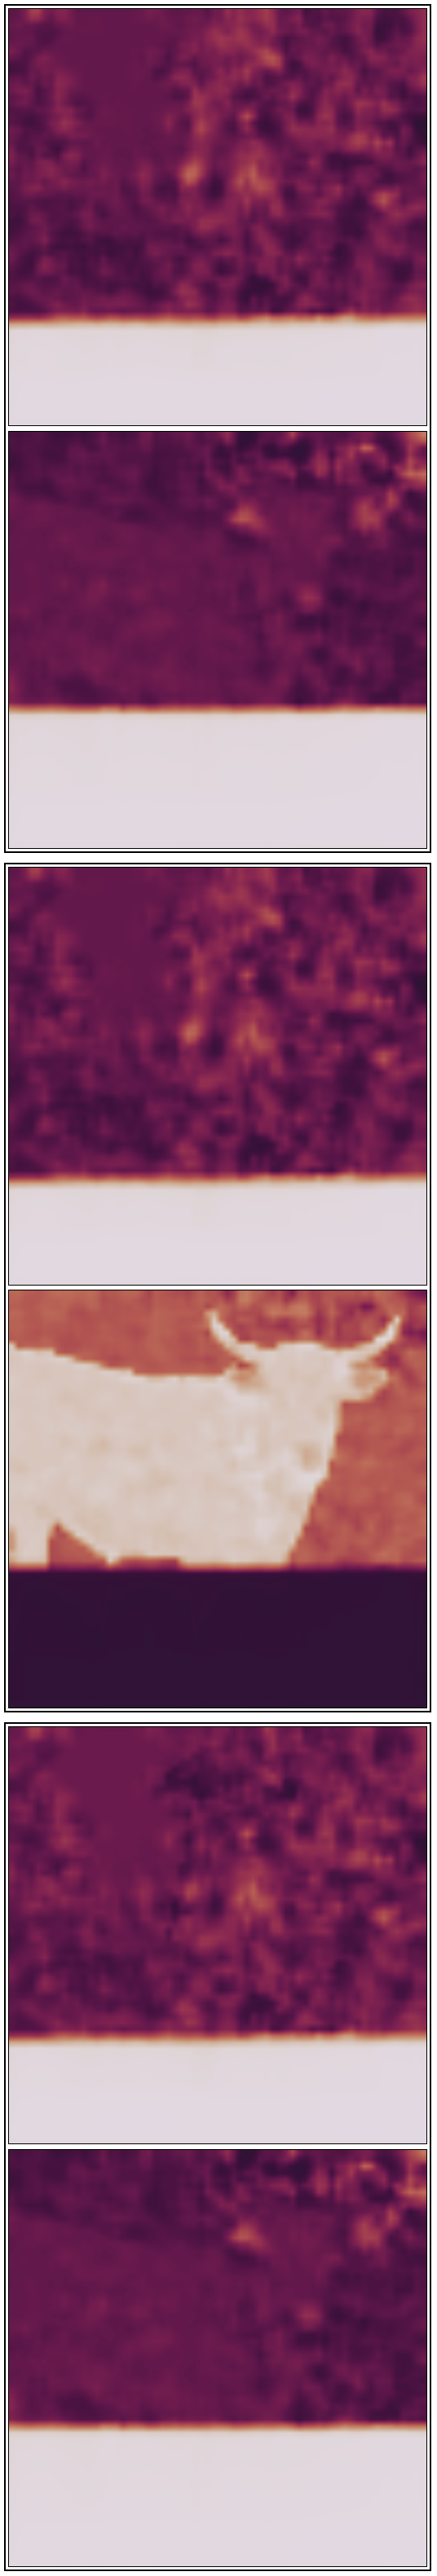

In [124]:
src_pca = torch.stack([feature_map_pca_heatmap(elem.detach()) for elem in src])
src_pca = resize(src_pca, (512, 512))
src_pca = rearrange(src_pca, "(b m c) h w -> b c m h w", b=b, m=m)
src_pca[0].chans

In [125]:
# Run the transformer to fuse the dense embeddings and sparse embeddings
with torch.no_grad():
    src = rearrange(src, "(b m c) d h w -> b m c d h w", b=b, m=m, c=c)
    sparse_embeddings = rearrange(
        sparse_embeddings, "(b m c) n d -> b m c n d", b=b, m=m, c=c
    )
    src = la.prompt_encoder.sparse_dense_fusion(
        src, pos_src, sparse_embeddings, chunk_size=None
    )
    src = rearrange(src, "b d h w -> b d (h w)")
    embeddings = nn.functional.adaptive_avg_pool1d(src, (1)).squeeze(2)  # (BMC, D)
    embeddings = rearrange(embeddings, "(b m c) d -> b m c d", b=b, m=m, c=c)

    embeddings = la.prompt_encoder.prompt_class_information_merge(embeddings, flag_examples)

    # Average over examples removing padding embeddings
    masked_embeddings = embeddings * flag_examples.unsqueeze(-1)
    normalizer = flag_examples.clone().unsqueeze(-1).sum(dim=1).float()
    normalizer[normalizer == 0] = (
        1  # Put 1 in padding to avoid division by 0 (logits will be put to -inf)
    )

    class_embeddings = masked_embeddings.sum(dim=1) / normalizer
    pe_result = {
        ResultDict.CLASS_EMBS: class_embeddings,
        ResultDict.EXAMPLES_CLASS_SRC: src,
        ResultDict.EXAMPLES_CLASS_EMBS: embeddings,
    }

In [126]:
src

tensor[6, 256, 4096] n=6291456 (24Mb) x∈[-3.629, 4.381] μ=-0.000 σ=0.941

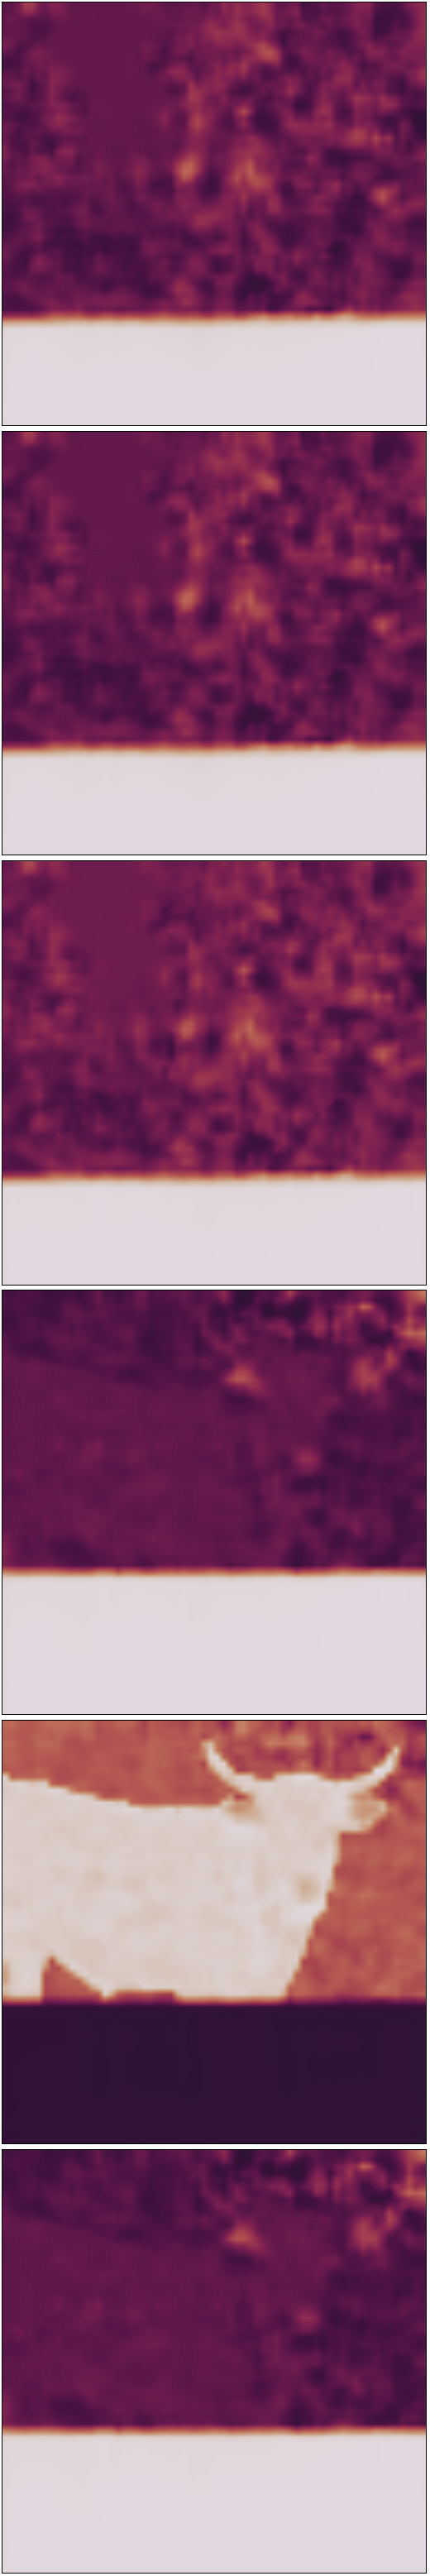

In [127]:
src_pca = torch.stack([feature_map_pca_heatmap(elem.detach()) for elem in rearrange(src, "(b m c) d (h w) -> (b m c) d h w", c=c, m=m, h=h, w=w)])
src_pca = resize(src_pca, (512, 512))
src_pca.chans

In [128]:
support_embeddings=prompt_embeddings
image_pe=la.get_dense_pe()
with torch.no_grad():
    b, d, h, w = query_embeddings.shape
    class_embeddings = la.mask_decoder._get_class_embeddings(pe_result)

    class_embeddings, query_embeddings = la.mask_decoder.transformer(
        query_embeddings, image_pe, class_embeddings
    )

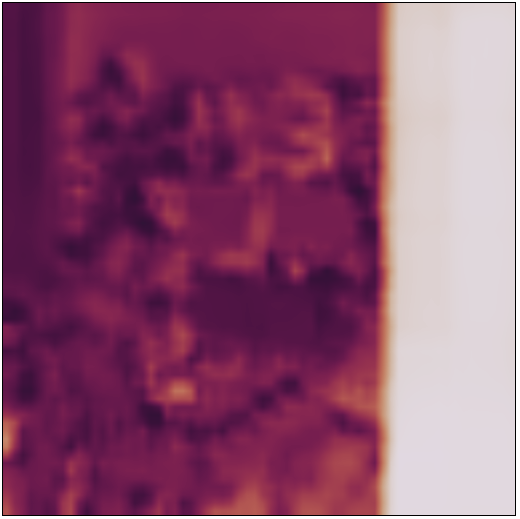

In [129]:
q_f = rearrange(query_embeddings, "b (h w) d -> b d h w", h=h, w=w)
q_f_pca = torch.stack([feature_map_pca_heatmap(elem.detach()) for elem in q_f])
q_f_pca = resize(q_f_pca, (512, 512))
q_f_pca.chans

In [130]:
with torch.no_grad():
    query_embeddings = rearrange(query_embeddings, "b (h w) c -> b c h w", h=h)

    upscaled_embeddings, class_embeddings = la.mask_decoder._upscale(
        query_embeddings, class_embeddings
    )
    upscaled_embeddings = la.mask_decoder._spatial_convs(upscaled_embeddings)

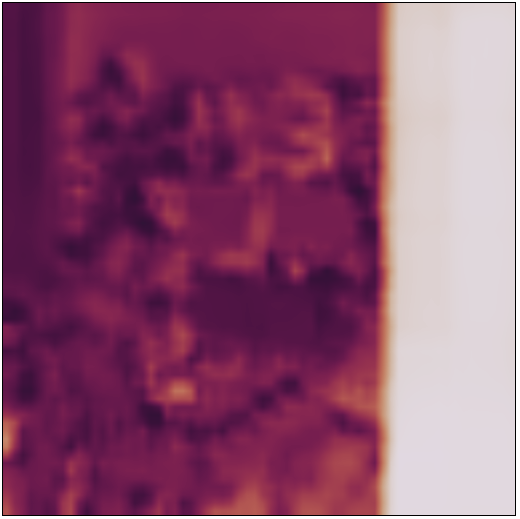

In [131]:
q_fu_pca = torch.stack([feature_map_pca_heatmap(elem.detach()) for elem in query_embeddings])
q_fu_pca = resize(q_f_pca, (512, 512))
q_fu_pca.chans

In [132]:
seg = la.mask_decoder._classify(upscaled_embeddings, class_embeddings, flag_examples)

In [134]:
with torch.no_grad():
    seg = la(batch_dict)

In [136]:
seg

{<ResultDict.LOGITS: 'logits'>: tensor[1, 3, 500, 500] n=750000 (2.9Mb) x∈[-3.371, 2.533] μ=-0.100 σ=0.678 -Inf!,
 <ResultDict.EXAMPLES_CLASS_EMBS: 'class_examples_embeddings'>: tensor[1, 2, 3, 256] n=1536 (6Kb) x∈[-4.119, 2.784] μ=-0.000 σ=0.956}

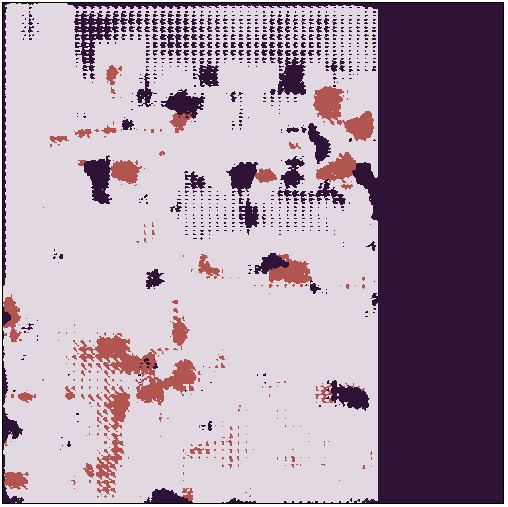

In [137]:
seg = seg['logits'].argmax(1)
seg = seg / seg.max()
seg.chans